# Exercici 1
## Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

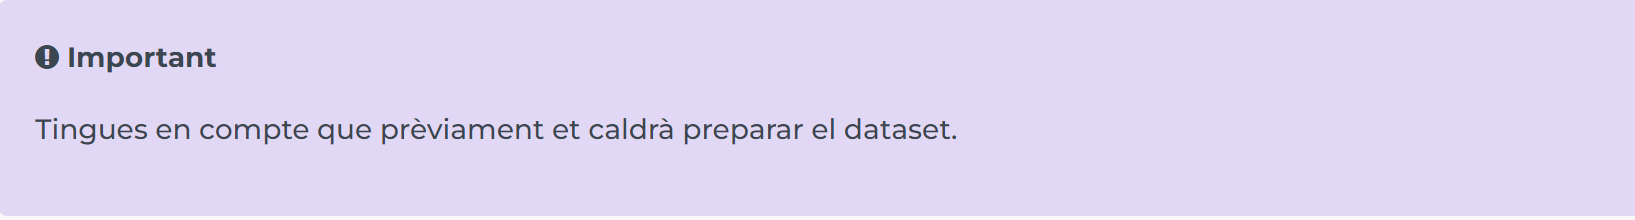

In [1]:
# Generic
import pandas as pd
import numpy as np

# Metodo de Normalización
from sklearn.preprocessing import RobustScaler

# Princial components analysis (PCA)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importación del método K-means
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Importación del método K-medoids
from sklearn_extra.cluster import KMedoids

# Filtrado de warnings
import warnings
warnings.filterwarnings('ignore')

#Clustering jerárquico: Dendograma y Modelo Aglomerativo
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Average silhouette
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
data = pd.read_csv('C:/Users/alpid/Downloads/Publicacions Facebook Thailandia.csv', sep=",")
data.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


### 1.1 Preproceso: analisis y limpieza de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

In [4]:
data.shape

(7050, 16)

In [5]:
data.isna().all()  # Aunque en el daata.info() ya se ve, verifico si hay columnas sin valores y las elimino

status_id           False
status_type         False
status_published    False
num_reactions       False
num_comments        False
num_shares          False
num_likes           False
num_loves           False
num_wows            False
num_hahas           False
num_sads            False
num_angrys          False
Column1              True
Column2              True
Column3              True
Column4              True
dtype: bool

In [6]:
data = data.dropna(axis=1, how="all")

In [7]:
data.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0


In [8]:
data.shape

(7050, 12)

In [9]:
# Elimino filas duplicadas en el DataFrame
data = data.drop_duplicates()

In [10]:
data.shape

(6999, 12)

A considerar:
- La columna de **status_id** no me aporta informacion así que la eliminaré.  
- La columna de **status_published** me aporta información que pudiera ser relevante para el clustering pero desgraciadamente K-mean no trabaja bien con fechas ni horas porque aunque las haya descompuesto en componentes numéricos, el algoritmo se basa en la distancia euclidiana y puede no ser apropiado para datos de fecha y hora, y menos si tengo que escalar las características numéricas, arriesgandome a tener reultados absurdos.  
Así que también la eliminaré.  
- Con la columna de **status_type** que distingue si es video, photo, etc,... tengo dos opciones para manejarla:  
(1) codificarlas con label Encoder  
(2) convertir cada tipo en columnas dummies de 0 o 1.  
En este caso, Label Encoder no es apropiado porque no se trata de categorias con un orden o una jeraquía implícita, y aunque añadir columnas incrementa el número de características, no hay tantas columnas y he elminiado ya algunas, así que crearé las dummies, por si son relevantes para las agrupaciones.


In [11]:
data = data.drop(["status_id", "status_published"], axis=1)

In [12]:
data.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,512,262,432,92,3,1,1,0
1,photo,150,0,0,150,0,0,0,0,0
2,video,227,236,57,204,21,1,1,0,0
3,photo,111,0,0,111,0,0,0,0,0
4,photo,213,0,0,204,9,0,0,0,0


In [13]:
data.shape

(6999, 10)

In [14]:
data = pd.get_dummies(data, columns=['status_type'])
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video
0,529,512,262,432,92,3,1,1,0,0,0,0,1
1,150,0,0,150,0,0,0,0,0,0,1,0,0
2,227,236,57,204,21,1,1,0,0,0,0,0,1
3,111,0,0,111,0,0,0,0,0,0,1,0,0
4,213,0,0,204,9,0,0,0,0,0,1,0,0


In [15]:
data.shape

(6999, 13)

Verificaré de forma gráffica si hay outliers.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'num_reactions'),
  Text(1, 0, 'num_comments'),
  Text(2, 0, 'num_shares'),
  Text(3, 0, 'num_likes'),
  Text(4, 0, 'num_loves'),
  Text(5, 0, 'num_wows'),
  Text(6, 0, 'num_hahas'),
  Text(7, 0, 'num_sads'),
  Text(8, 0, 'num_angrys'),
  Text(9, 0, 'status_type_link'),
  Text(10, 0, 'status_type_photo'),
  Text(11, 0, 'status_type_status'),
  Text(12, 0, 'status_type_video')])

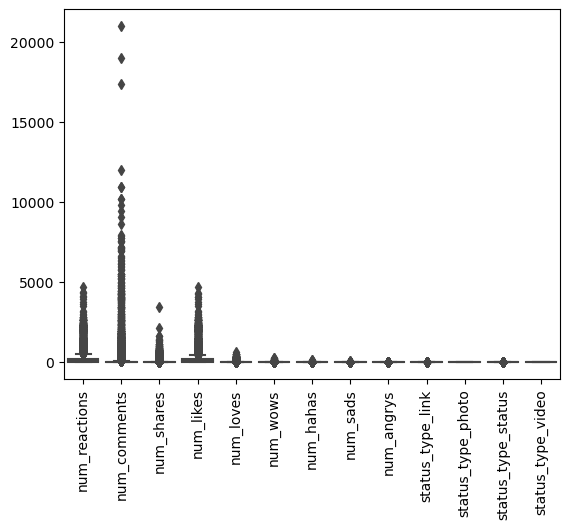

In [16]:
sns.boxplot(data)
plt.xticks(rotation='vertical')

Veo que hay un elevado numero de outliers pero, salvo en el caso de los outliers de Num_commnets que claramente estan distanciados de la gran mayoria de resutaldos, el resto no parecen estar tan lejos de sus congeneres, por eso tengo mis dudas de que no sean relevantes para el analisis así que los dejo y procedo a la normalización.  
  
Dado que los outliers peuden ser relevantes voy a usar como método de normalización el RobustScaler que es menos sensible a estos.

### 1.2 Preproceso: Normalización

In [17]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data)
df = pd.DataFrame(data_scaled, columns = data.columns)
df.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,-1.0,0.0,1.0
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video
count,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000
mean,0.839169,10.070549,10.064652,0.926950,4.250512,1.252893,0.697957,0.232605,0.110159,0.009001,-0.393628,0.051293,0.333333
std,2.275783,40.579228,33.011726,2.663941,13.368957,8.725551,3.970912,1.481105,0.688582,0.094454,0.488589,0.220611,0.471438
min,-0.291457,-0.181818,0.000000,-0.345455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,-0.206030,-0.181818,0.000000,-0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.793970,0.818182,1.000000,0.757576,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,23.376884,953.909091,856.000000,28.200000,219.000000,278.000000,157.000000,51.000000,31.000000,1.000000,0.000000,1.000000,1.000000


### 1.3 Preproceso: Princial components analysis (PCA)

Veamos si es posible reducir dimensiones en función de la influencia de cada variable.

In [19]:
pca = PCA().fit(df)

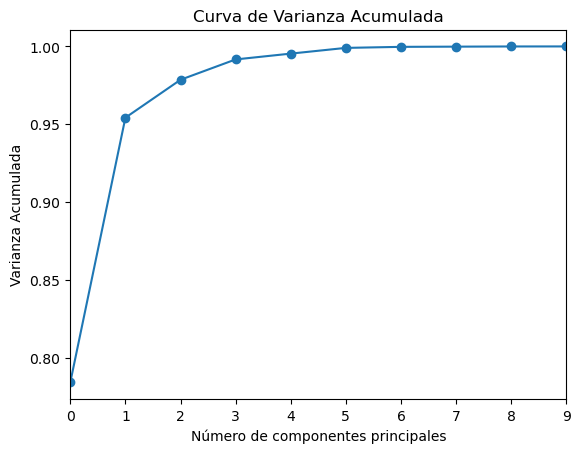

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.xlim([0, 9])
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza Acumulada")
plt.title("Curva de Varianza Acumulada")
plt.show()

##### Vamos a ver cuantos componentes vamos a necesitar. Por el grafico vemos que esta entre 1 y 2 capturo mas del 95% de la varianza. Voy a intentar conservar por encima del 97%.

In [21]:
pca = PCA(.97).fit(df)
print('Número de componentes para conservar el 97% de la varianza es:', pca.n_components_)

Número de componentes para conservar el 97% de la varianza es: 3


Escojo por tanto 3 componentes para la agrupación d variables conservando el 97% de la información:

In [22]:
pca = PCA(n_components=3)
pca.fit(df)
df_pca = pd.DataFrame(pca.transform(df), columns=["pca1", "pca2", "pca3"], index=data.index) 
df_pca.head()

,pca1,pca2,pca3
0,48.146219,39.281738,-1.811099
1,-14.876282,-2.242583,-0.564626
2,3.375964,3.441262,-0.012490
3,-14.880365,-2.249211,-0.587833
4,-14.270582,-1.396058,1.128764


### 1.3 K-means

El algoritmo K-means (MacQueen, 1967) agrupa las observaciones en un número predefinido de K clusters de forma que, la suma de las varianzas internas de los clusters, sea lo menor posible. 

Para utilizar el algoritmo K-means, hay que definir el número de K de clusters para lo que usaré el método Elbow para buscar dicho número.Posteriormente utilizaré el método Average Silhouette para obtener el mejor número de clusters.


### 1.3.1 Número óptimo de clusters con el metodo del codo (Elbow)

El método Elbow, también conocido como método del codo, sigue una estrategia de probar un rango de valores del hiperparámetro en cuestión, representar gráficamente los resultados obtenidos con cada uno, e identificar aquel punto de la curva (codo) a partir del cual la mejora deja de ser notable.  
En los casos de partitioning clustering, como por ejemplo K-means, las observaciones se agrupan de una forma tal que se minimiza la varianza total intra-cluster.  
El método Elbow calcula la varianza total intra-cluster en función del número de clusters y escoge como óptimo aquel valor a partir del cual añadir más clusters apenas consigue mejoría.

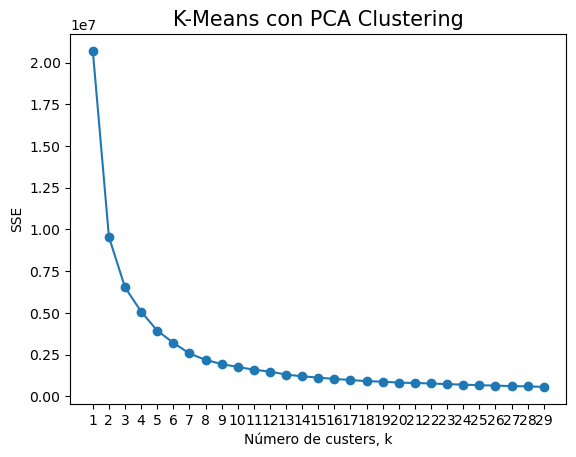

In [23]:
from sklearn.cluster import KMeans

ks = range(1, 30)
# SSE es (Sum of Squared errors)
SSE = []

for k in range(1, 30):
  
    model = KMeans(n_clusters=k, random_state=1)   # Crea KMeans instancias con K clusters: model
    model.fit(df_pca)     # Entrena el modelo para cada número de clusters k
    SSE.append(model.inertia_) # Crea la lista de errores cuadráticos para cada número de clusters

    #grafico el resultado para obtenr por cada cantidad de cllusters k la suma de errores cuadráticos
plt.plot(ks, SSE, '-o')
plt.xlabel('Número de custers, k')
plt.ylabel('SSE')
plt.title('K-Means con PCA Clustering', fontsize=15)
plt.xticks(ks)
plt.show()

In [24]:
from kneed import KneeLocator
kl = KneeLocator(ks, SSE, curve="convex", direction="decreasing")
print('Número de clusters convenientes:', kl.elbow)

Número de clusters convenientes: 6


### 1.3.2 Kmeans Clustering

El algoritmo empleado sigue el siguiente proceso:

- Especificar el número K de clusters que se quieren crear.
- Seleccionar de forma aleatoria k observaciones del set de datos como centroides iniciales.
- Asignar cada una de las observaciones al centroide más cercano.
- Para cada uno de los K clusters generados en el paso 3, recalcular su centroide.
- Repetir los pasos 3 y 4 hasta que las asignaciones no cambien o se alcance el número máximo de iteraciones establecido.

In [25]:
k_means = KMeans(n_clusters=6, random_state=1)
k_means.fit(df_pca)

#predicciones
k_means_pred = k_means.predict(df_pca)
k_means_pred

array([3, 0, 0, ..., 0, 0, 0])

Y ahora creo una copia de la base de datos df y le añado la columna con los clusters obtenidos

In [26]:
df_cluster = df.copy()

df_cluster['Cluster_K-means'] = k_means_pred
df_cluster.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,Cluster_K-means
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,-1.0,0.0,1.0,3
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [27]:
df_cluster['Cluster_K-means'].value_counts()

0    6168
3     600
4     111
1      85
2      32
5       3
Name: Cluster_K-means, dtype: int64

Observamos que el cluster 0 se lleva el 88% del total de datos y el Cluster 3 el 8,6%.

### Visualización de los clusters

**a) Comparación entre clusters**

<Axes: xlabel='Cluster_K-means', ylabel='count'>

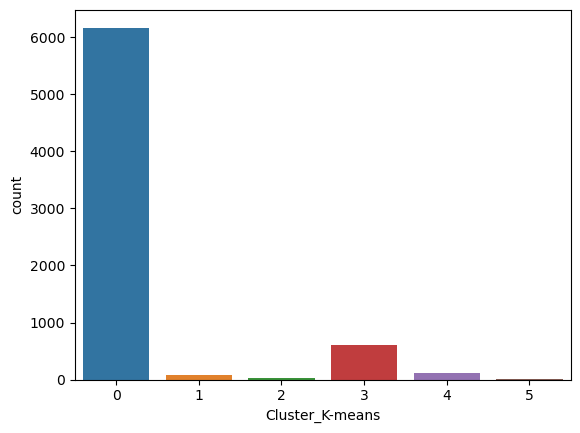

In [28]:
sns.countplot(x = df_cluster['Cluster_K-means'])

Observamos, como indicado antes, que el cluster 0 se lleva el 88% del total de datos y el Cluster 3 el 8,6%.

**b) Visualización de los clusters en función de las variables**

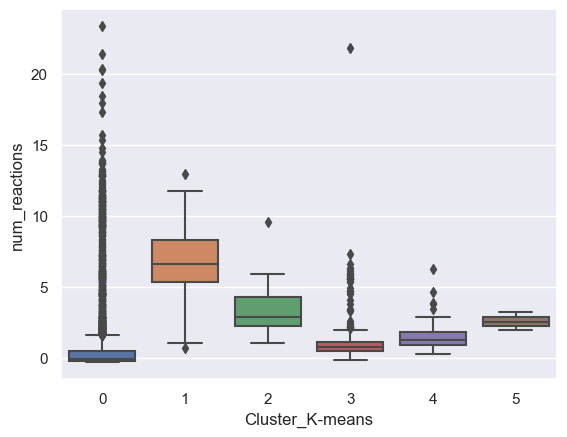

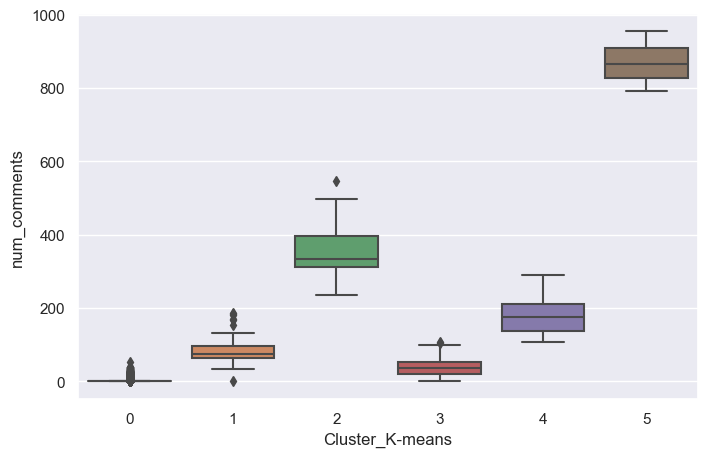

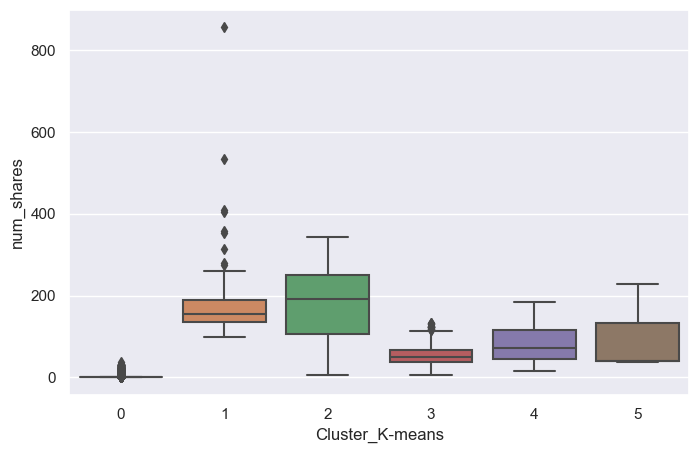

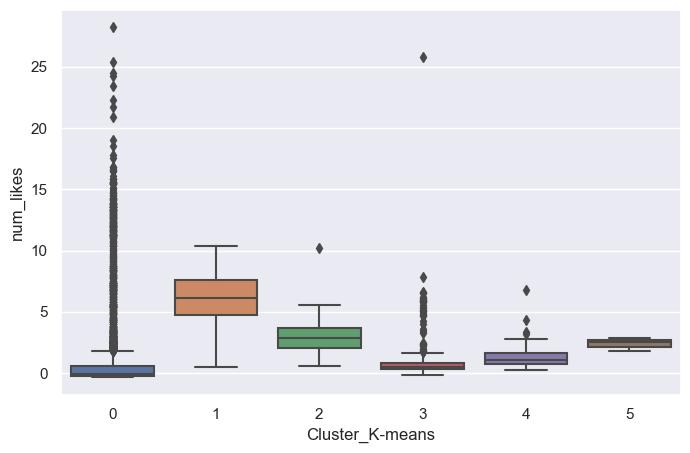

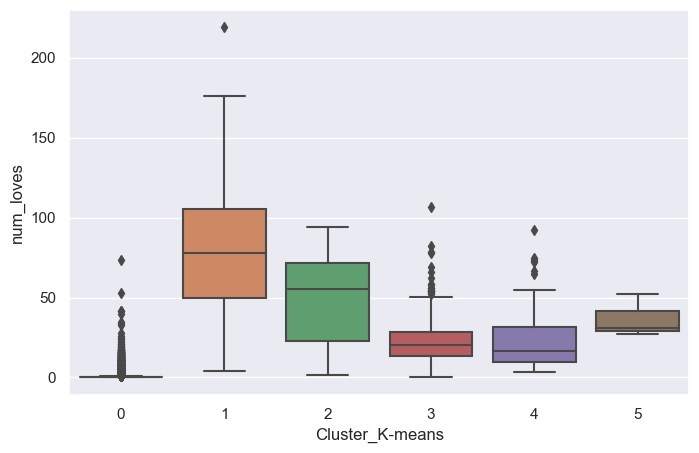

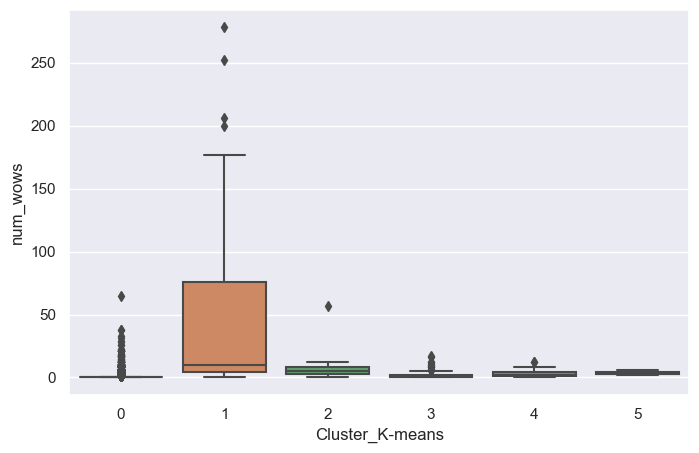

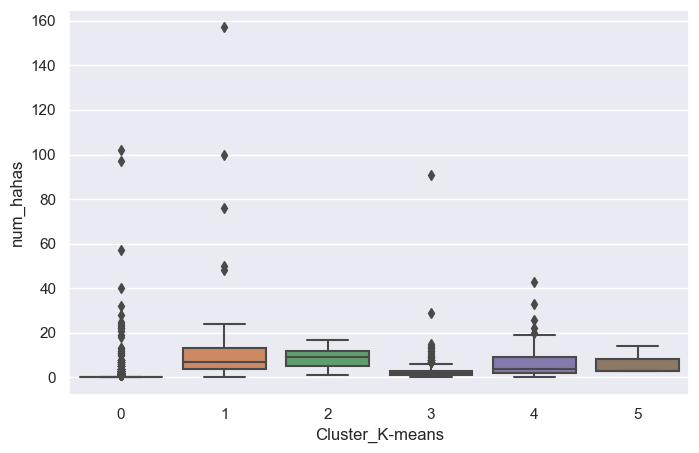

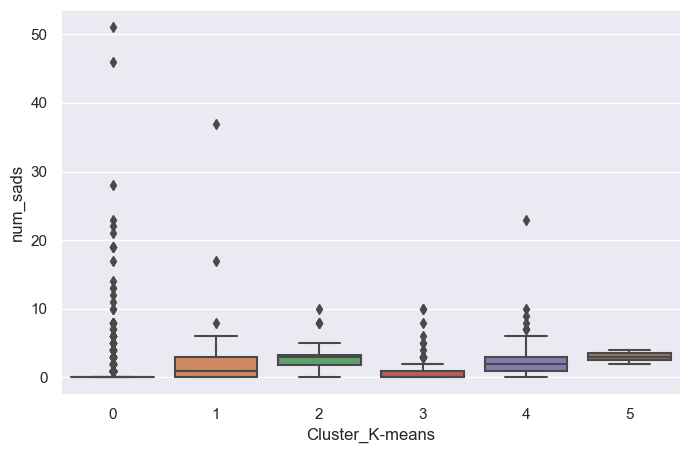

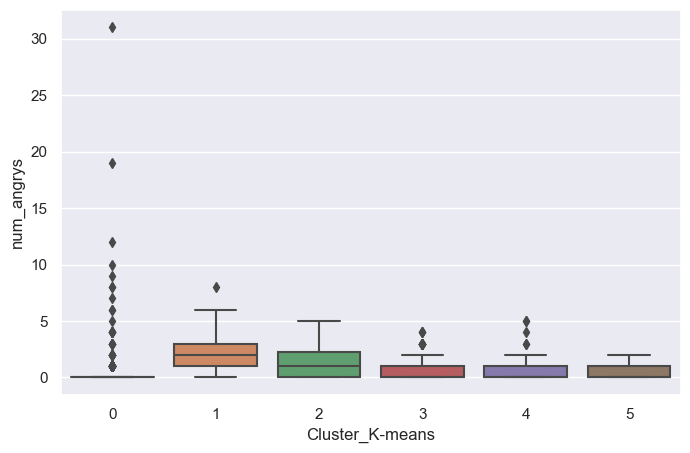

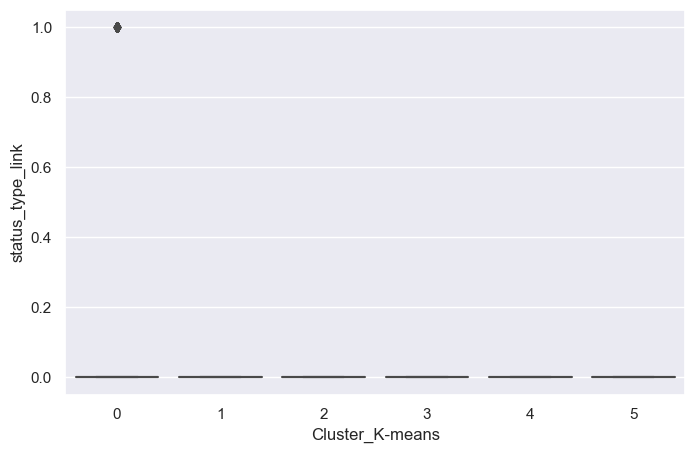

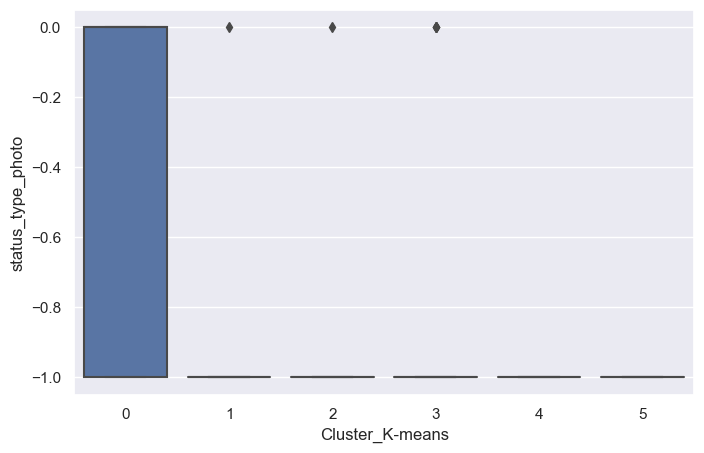

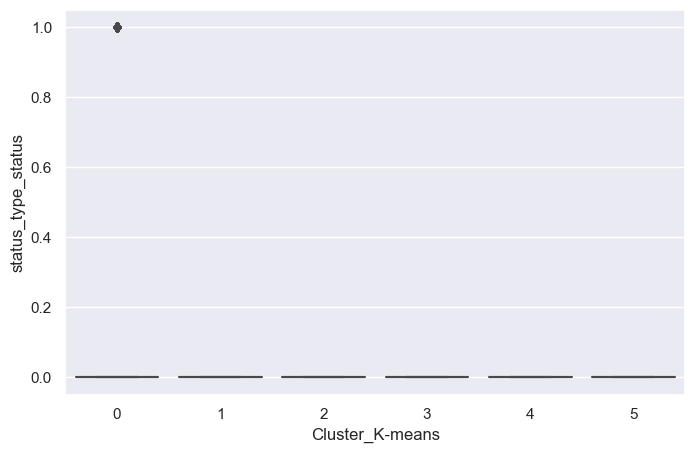

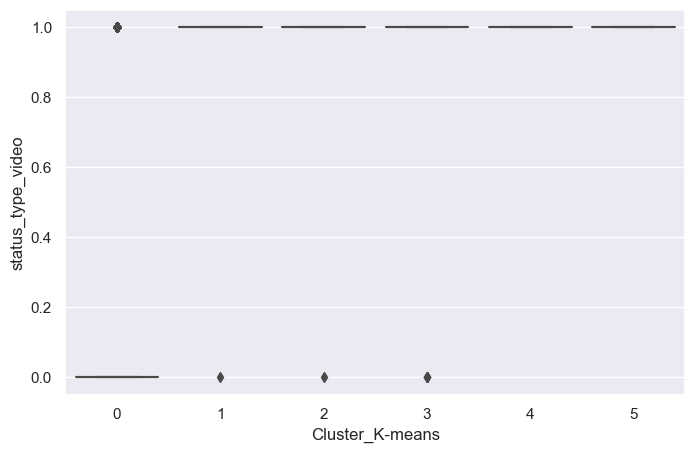

In [29]:
columns = df_cluster.columns[:-1]
    
for i in columns:
    plt.figure()
    sns.set(rc={"figure.figsize":(8, 5)})
    sns.boxplot(x= "Cluster_K-means", y=i, data=df_cluster)

Observamos que: num_reactions, num_comments, num_shares, mun_likes y num_loves tienen valores de mediana y de desviación estándar para cada cluster bastante diferentes, sin embargo, el resto de variables, no presentan grandes diferencias en la distribución de los cuartiles.  
Otro factor destacable es la existencia de numerosos outliers en la mayoría de las variables siendo en num_reactions donde mas cantidad hay, lo que probablemente está distorsionando la clasificación de los valores en los diferentes clústers.

### 1.4 K-medoids

Es un método de clustering similar a K-means pero mas robusto que K-means cuando hay outliers o ruido.  
Necesita igualmente la definición previa del número de clusters.  
La diferencia es que, en K-medoids, cada cluster está representado por una observación presente en el cluster (medoid), mientras que en K-means cada cluster está representado por su centroide, que se corresponde con el promedio de todas las observaciones del cluster, pero con ninguna en particular.

In [30]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=6, random_state=1).fit(df_pca)
labels = kmedoids.labels_

In [31]:
df_cluster_kmd = df.copy()

df_cluster_kmd['Cluster_K-medoids'] = labels
df_cluster_kmd.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,Cluster_K-medoids
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,-1.0,0.0,1.0,4
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,3
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [32]:
df_cluster_kmd['Cluster_K-medoids'].value_counts()

1    4719
0    1195
4     353
3     342
2     270
5     120
Name: Cluster_K-medoids, dtype: int64

### Visualización de los clusters

**a) Comparación entre clusters**

<Axes: xlabel='Cluster_K-medoids', ylabel='count'>

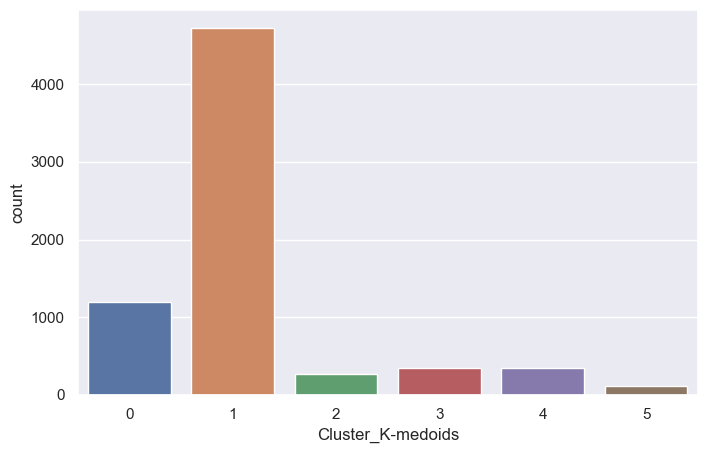

In [33]:
sns.countplot(x = df_cluster_kmd['Cluster_K-medoids'])

Observamos que con K-medoids, hay una redistribución por clusters, donde el cluster 0 acumula el 17% y el cluster 1 el 67,5%

**b) Visualización de los clusters en función de las variables**

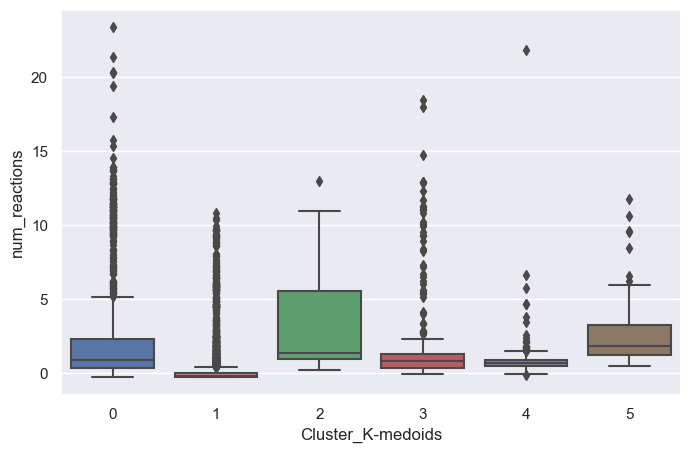

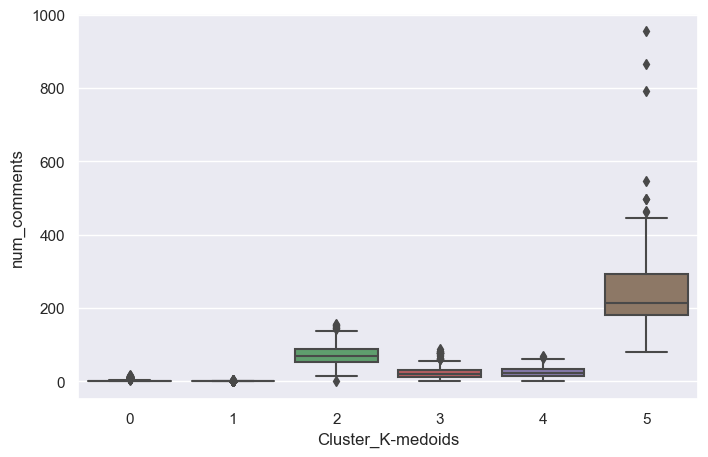

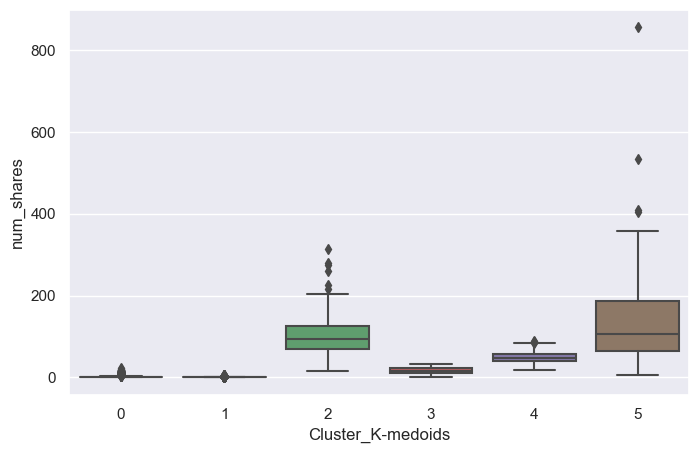

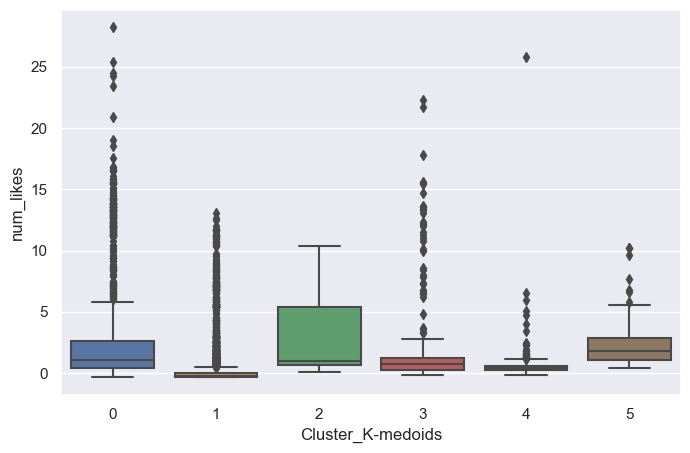

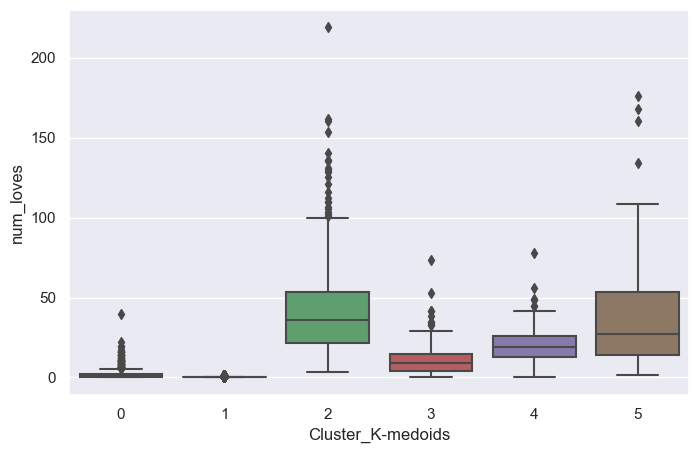

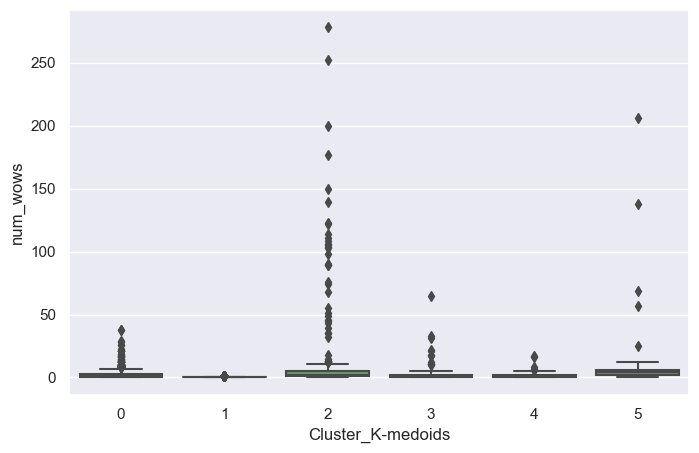

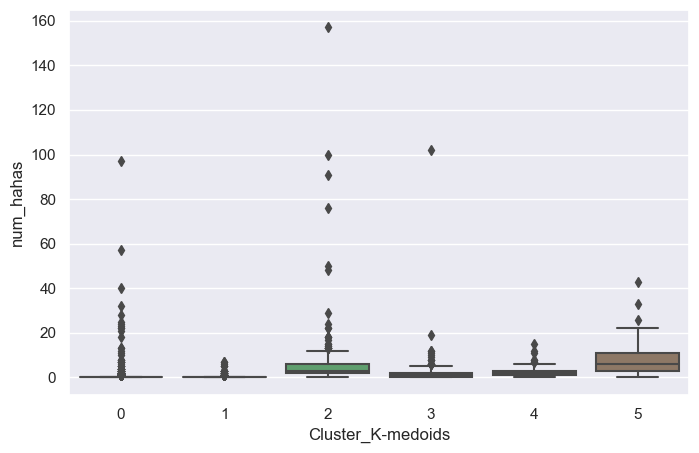

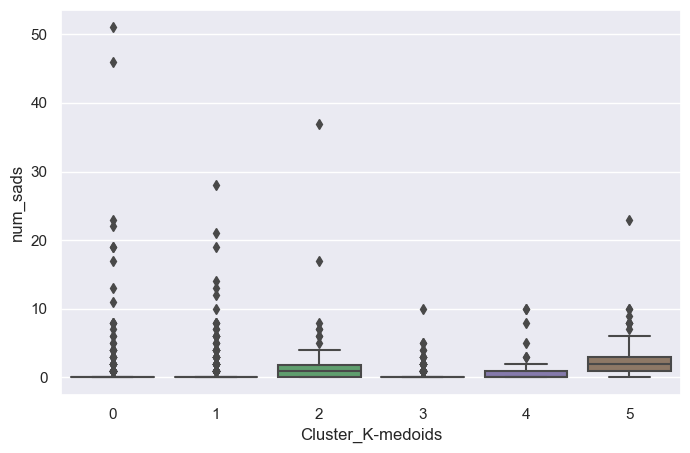

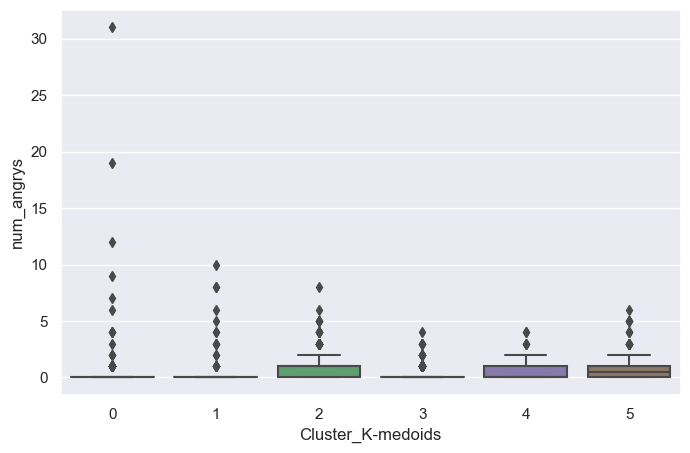

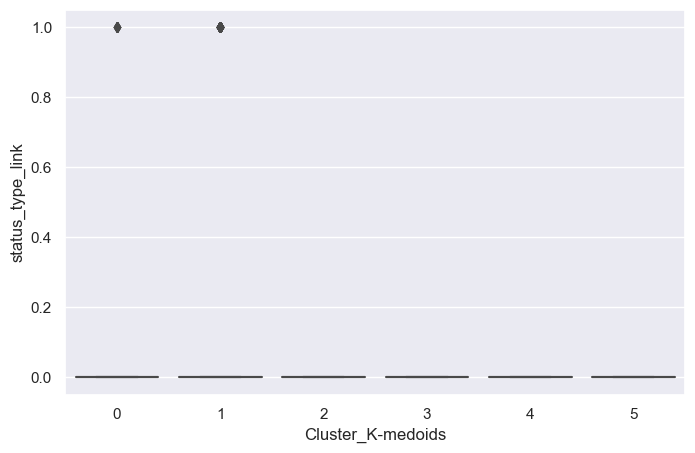

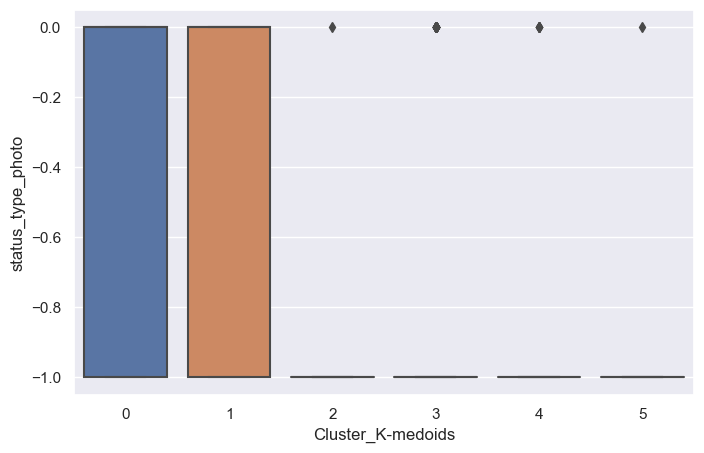

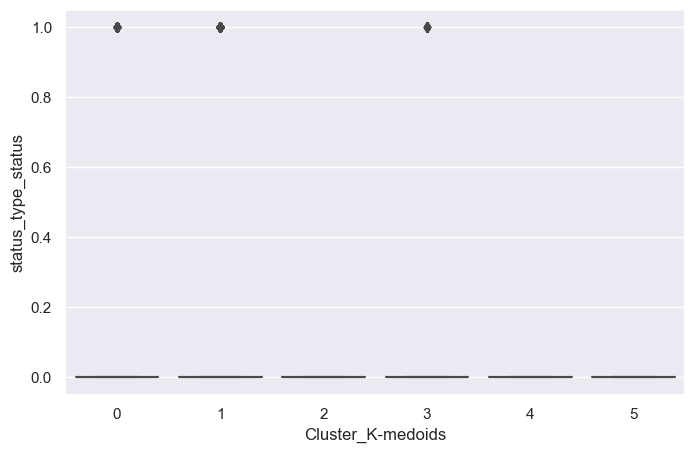

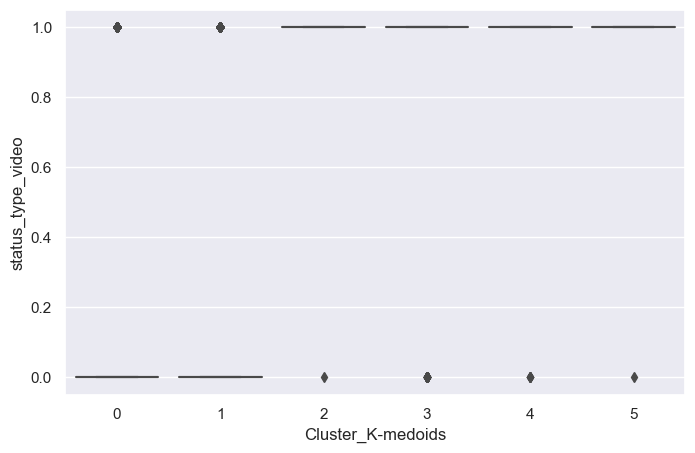

In [34]:
columns = df_cluster_kmd.columns[:-1]
    
for i in columns:
    plt.figure()
    sns.set(rc={"figure.figsize":(8, 5)})
    sns.boxplot(x= "Cluster_K-medoids", y=i, data=df_cluster_kmd)

Seguimos observando numerosos outliers, y esta vez parece que ha distribuido entre el cluster 1 y 2 el status type photo.

# Exercici 2
## Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.

Usaremos el método Ward, la distancias entre clústeres es la suma del cuadrado de las diferencias dentro de todos los clústeres.
Elegiremos el numero de clusters en funcion de la linea as larga sin cortes (extendiendo las lineas horizontales para comprobarlo).

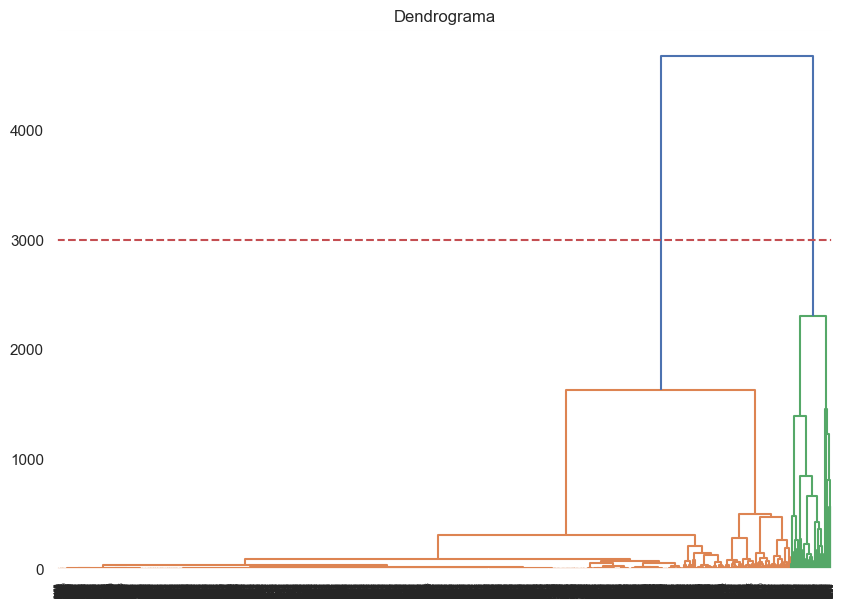

In [35]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(df_pca, method='ward'))
plt.axhline(y=3000, color='r', linestyle='--') #En este caso, esta linea corta las lineas mas largas. Es decir, dos clusters

Como deducimos ver a través del dendograma utlizaremos dos clusters.

**Modelo aglomerativo definidos el número de clusters**

In [36]:
from sklearn.cluster import AgglomerativeClustering
model_agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
model_agg.fit(df_pca)


AgglomerativeClustering(affinity='euclidean')

In [37]:
df_cluster_agg = df.copy()

df_cluster_agg['Cluster_Agg'] = model_agg.labels_
df_cluster_agg.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,Cluster_Agg
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,-1.0,0.0,1.0,1
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,1
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [38]:
df_cluster_agg['Cluster_Agg'].value_counts()

1    6629
0     370
Name: Cluster_Agg, dtype: int64

### Visualización de los clusters

**a) Comparación entre clusters**

<Axes: xlabel='Cluster_Agg', ylabel='count'>

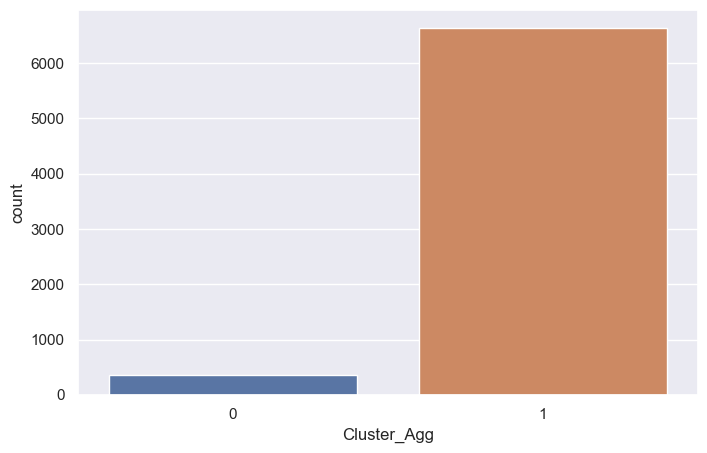

In [39]:
sns.countplot(x = df_cluster_agg['Cluster_Agg'])

**b) Visualización de los clusters en función de las variables**

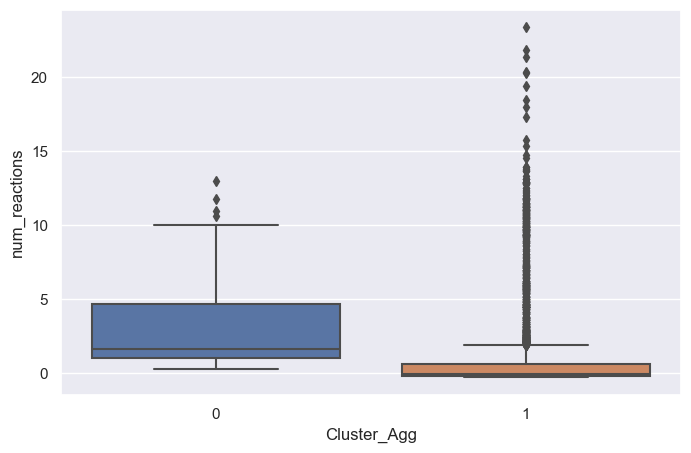

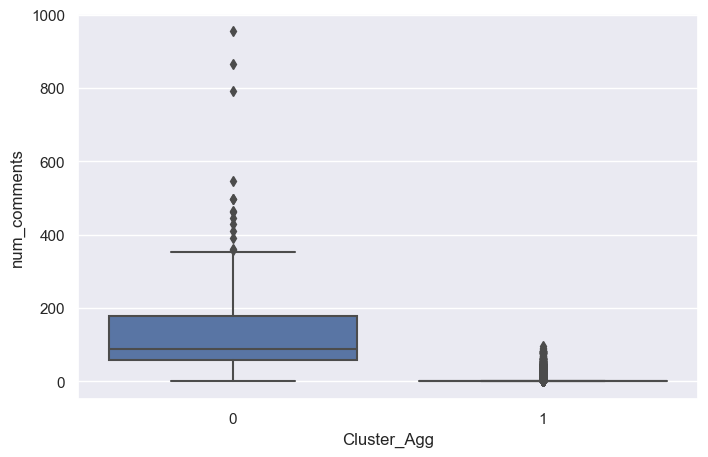

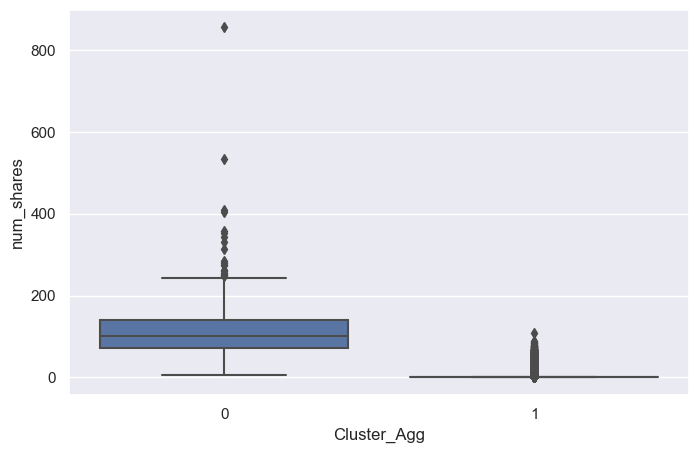

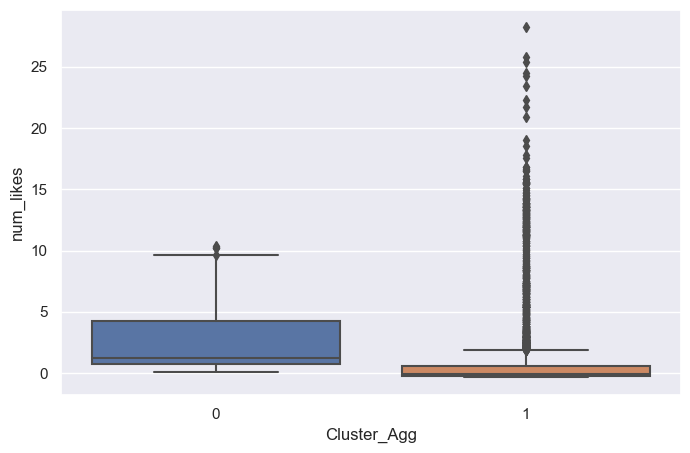

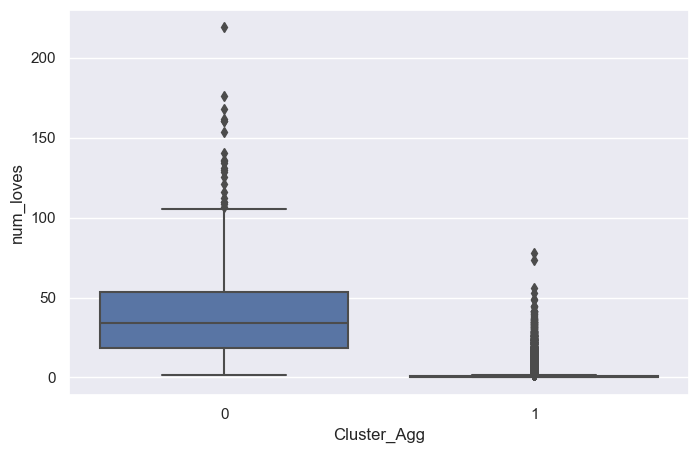

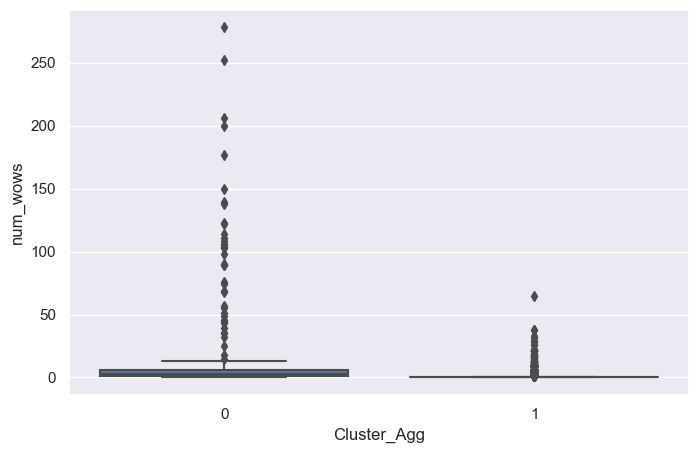

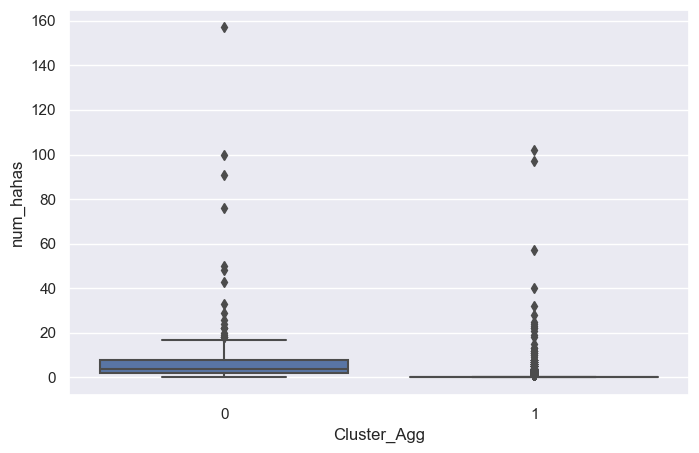

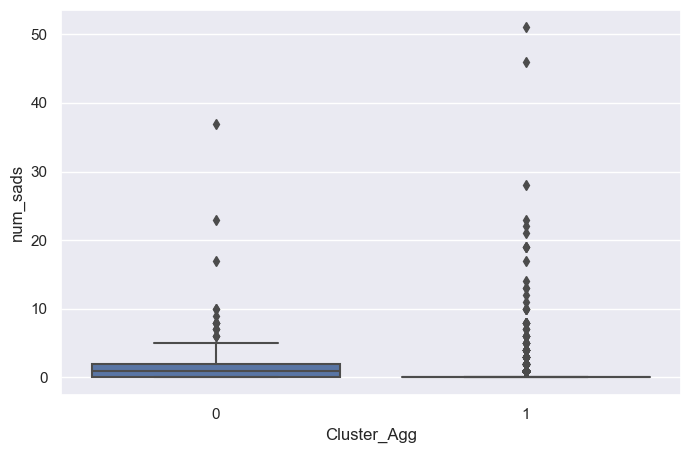

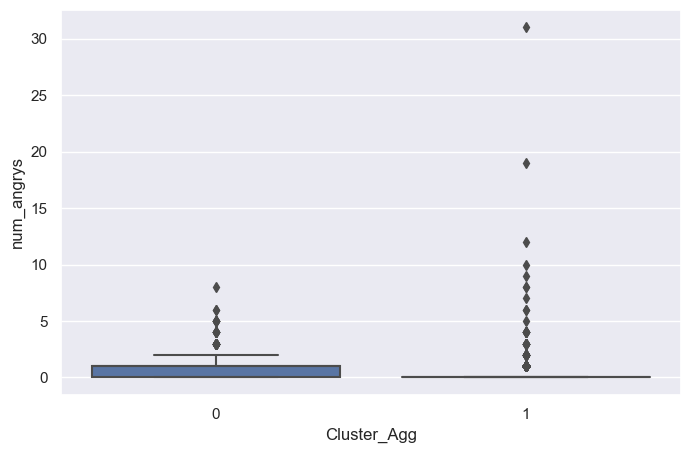

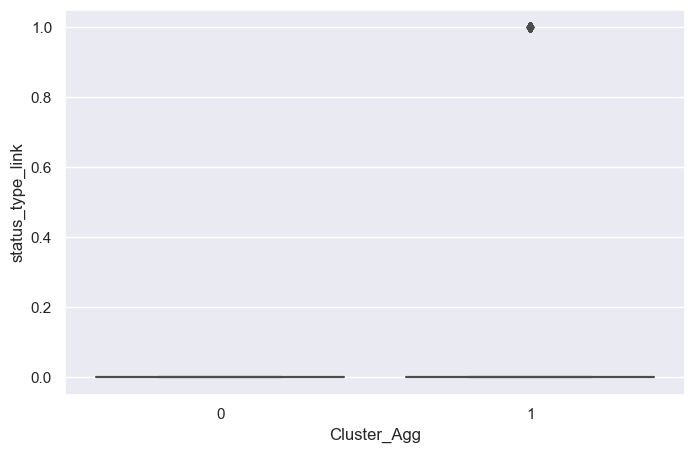

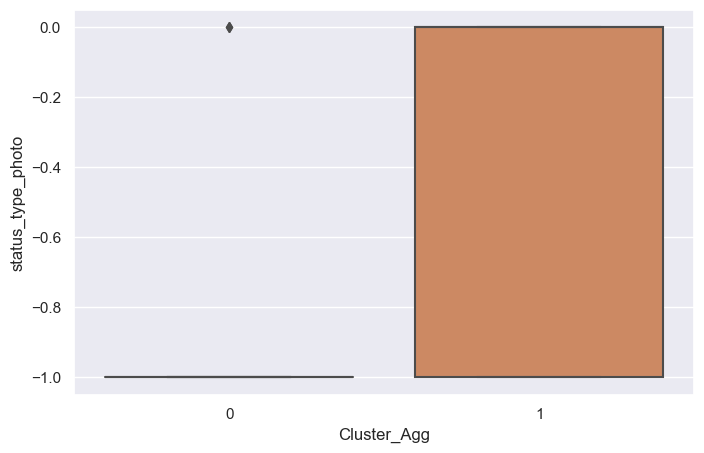

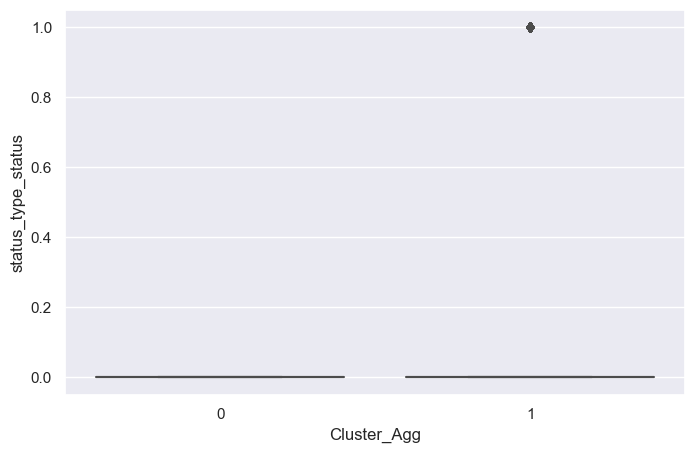

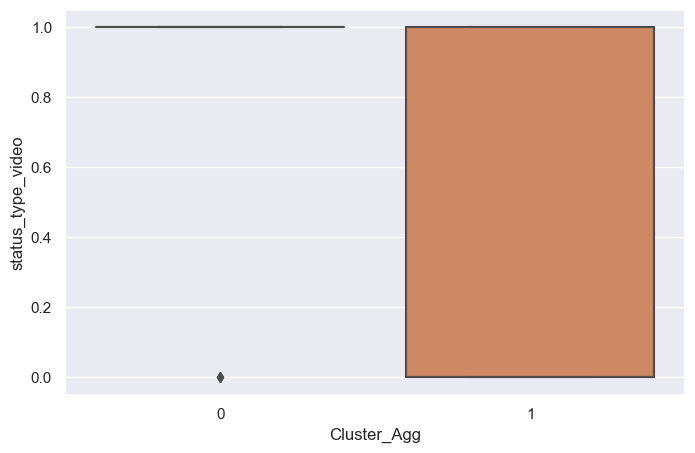

In [40]:
columns = df_cluster_agg.columns[:-1]
    
for i in columns:
    plt.figure()
    sns.set(rc={"figure.figsize":(8, 5)})
    sns.boxplot(x= "Cluster_Agg", y=i, data=df_cluster_agg)

# Exercici 3
## Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

El índice de rendimiento Silhouette se usa para evaluar la calidad de los clústeres obtenidos con los algoritmos de agrupación.  
#Se calcula la distancia entre cada muestra y todos los demás puntos de cada cluster, después se calcula media y se obtiene la distancia media.  
#El valor del índice Silhouette está entre -1 y 1.  
El cluster es denso y está bien diferenciado cuando el índice se acerca a 1.

In [41]:
from sklearn.metrics import silhouette_score


score_KM = silhouette_score(df_pca, k_means.labels_).round(2)
score_KMD = silhouette_score(df_pca, kmedoids.labels_).round(2)
score_agg = silhouette_score(df_pca, model_agg.labels_).round(2)

print('El resultado de la prueba de silhouette para el modelo k-means es de:', score_KM,
      '\nEl resultado de la prueba de silhouette para el modelo k-medoids es de:', score_KMD,
     '\nEl resultado de la prueba de silhouette para el modelo jerárquico es de:', score_agg)

El resultado de la prueba de silhouette para el modelo k-means es de: 0.86 
El resultado de la prueba de silhouette para el modelo k-medoids es de: 0.58 
El resultado de la prueba de silhouette para el modelo jerárquico es de: 0.89


Si quisiera saber cual es el numero de clusters mas apropiados para cada metodo?:

**a) K-means** 

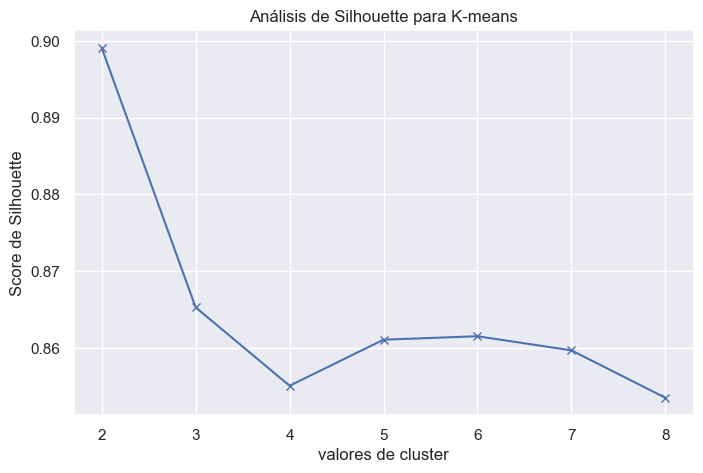

In [42]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_km = []
for num_clusters in range_n_clusters:
 
 # inicializo el kmeans
     kmeans = KMeans(n_clusters=num_clusters)
     kmeans.fit(df_pca)
     cluster_labels_km = kmeans.labels_
 
 # silhouette score
     silhouette_km.append(silhouette_score(df_pca, cluster_labels_km))

plt.plot(range_n_clusters,silhouette_km,'bx-')
    
plt.xlabel('valores de cluster') 
plt.ylabel('Score de Silhouette') 
plt.title('Análisis de Silhouette para K-means')
plt.show()

El mejor numero de clusters segun silhuette en este caso es 2 para K-means.

b) K-medoids

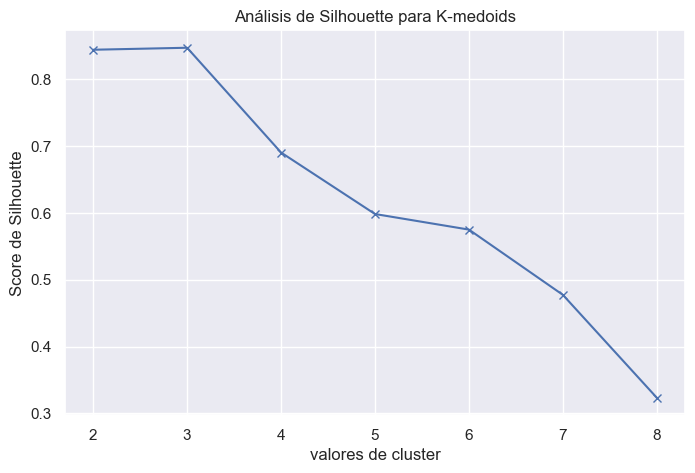

In [43]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_kmd = []
for num_clusters in range_n_clusters:
 
 # inicializo el kmeans
     kmedoids = KMedoids(n_clusters=num_clusters)
     kmedoids.fit(df_pca)
     cluster_labels_kmd = kmedoids.labels_
 
 # silhouette score
     silhouette_kmd.append(silhouette_score(df_pca, cluster_labels_kmd))

plt.plot(range_n_clusters,silhouette_kmd,'bx-')
    
plt.xlabel('valores de cluster') 
plt.ylabel('Score de Silhouette') 
plt.title('Análisis de Silhouette para K-medoids')
plt.show()

En este caso, indica que obtenemos resultados similares con 2 y 3 clusters para K-medoids.

c) Modelo aglomerativo:

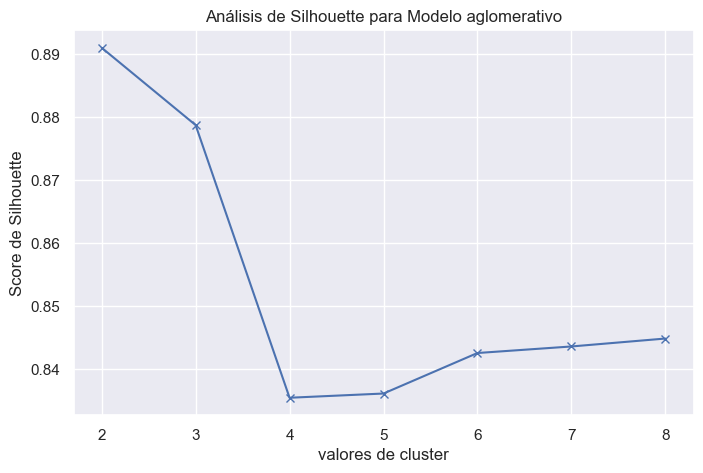

In [44]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_agg = []
for num_clusters in range_n_clusters:
 
 # inicializo el kmeans
     modelo_agg= AgglomerativeClustering(n_clusters=num_clusters)
     modelo_agg.fit(df_pca)
     cluster_labels_agg = modelo_agg.labels_
 
 # silhouette score
     silhouette_agg.append(silhouette_score(df_pca, cluster_labels_agg))

plt.plot(range_n_clusters,silhouette_agg,'bx-')
    
plt.xlabel('valores de cluster') 
plt.ylabel('Score de Silhouette') 
plt.title('Análisis de Silhouette para Modelo aglomerativo')
plt.show()

Recomienda 2 clusters tambien en el modelo aglomerativo.

De modo que si hacemos el calculo con dos clusters para cada caso obtenemos los siguientes resultados de Silhouette:

In [45]:
kmeans1 = KMeans(n_clusters= 2, random_state=1).fit(df_pca)
kmedoids1 = KMedoids(n_clusters= 2, random_state=1).fit(df_pca)
kmedoids2 = KMedoids (n_clusters = 3, random_state= 1).fit(df_pca)  #veré tambien el caso de 3 clusters.
modelo_agg1 = AgglomerativeClustering(n_clusters= 2).fit(df_pca)

score_KM1 = silhouette_score(df_pca, kmeans1.labels_).round(2)
score_KMD1 = silhouette_score(df_pca, kmedoids1.labels_).round(2)
score_KMD2 = silhouette_score(df_pca, kmedoids2.labels_).round(2)
score_agg1 = silhouette_score(df_pca, model_agg.labels_).round(2)

print('El resultado de la prueba de silhouette para el modelo k-means con 2 cluster es de:', score_KM1,
      '\nEl resultado de la prueba de silhouette para el modelo k-medoids con 2 cluster es de:', score_KMD1,
      '\nEl resultado de la prueba de silhouette para el modelo k-medoids con 3 cluster es de:', score_KMD2,
      '\nEl resultado de la prueba de silhouette para el modelo jerárquico con 2 cluster es de:', score_agg1)

El resultado de la prueba de silhouette para el modelo k-means con 2 cluster es de: 0.9 
El resultado de la prueba de silhouette para el modelo k-medoids con 2 cluster es de: 0.84 
El resultado de la prueba de silhouette para el modelo k-medoids con 3 cluster es de: 0.85 
El resultado de la prueba de silhouette para el modelo jerárquico con 2 cluster es de: 0.89
